In [1]:
from quantsight import Quantsight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

api_key = "Add Quantsight API key"
openai_api_key = "Add OpenAI API key"

qs = Quantsight(
    api_key=api_key,
    openai_api_key=openai_api_key,
)

In [2]:
candles = qs.get_ohlcv(
    limit=1e6,
)

In [12]:
qs.llm_query(
    df=candles,
    query="Simulate a pairs trading strategy, by implementing the following rules;"
          " 1. Extract the price of BTC and ETH and compute their returns"
          " 2. Calculate the spread and the zscore of the spread"
          " 3. Get the cumulative return of the strategy by:"
          "     1. Go long BTC and short ETH when the zscore is greater than 2"
          "     2. Go short BTC and long ETH when the zscore is smaller than -2"
          "     3. Exit all positions when the zscore is between 1 and -1"
          " 4. In separate sublpots, plot the spread, score, and cumulative return of the strategy",
    pre_process_df=True,
)



> Entering new AgentExecutor chain...
Thought: We need to extract the price of BTC and ETH from the dataframe and compute their returns. Then we need to calculate the spread and zscore of the spread. Finally, we need to implement the trading strategy and plot the spread, zscore, and cumulative return in separate subplots.
Action: Use pandas to extract the price of BTC and ETH and compute their returns.
Action Input:
```
btc_df = df[df['ticker'] == 'BTC-USD-SWAP']
eth_df = df[df['ticker'] == 'ETH-USD-SWAP']
btc_returns = btc_df['close_price'].pct_change()
eth_returns = eth_df['close_price'].pct_change()
```
Observation: Use pandas to extract the price of BTC and ETH and compute their returns. is not a valid tool, try another one.
Thought:I need to use python_repl_ast to execute the code.
Action: Use python_repl_ast to execute the code.
Action Input:
```
btc_df = df[df['ticker'] == 'BTC-USD-SWAP']
eth_df = df[df['ticker'] == 'ETH-USD-SWAP']
btc_returns = btc_df['close_price'].pct_chang

KeyboardInterrupt: 

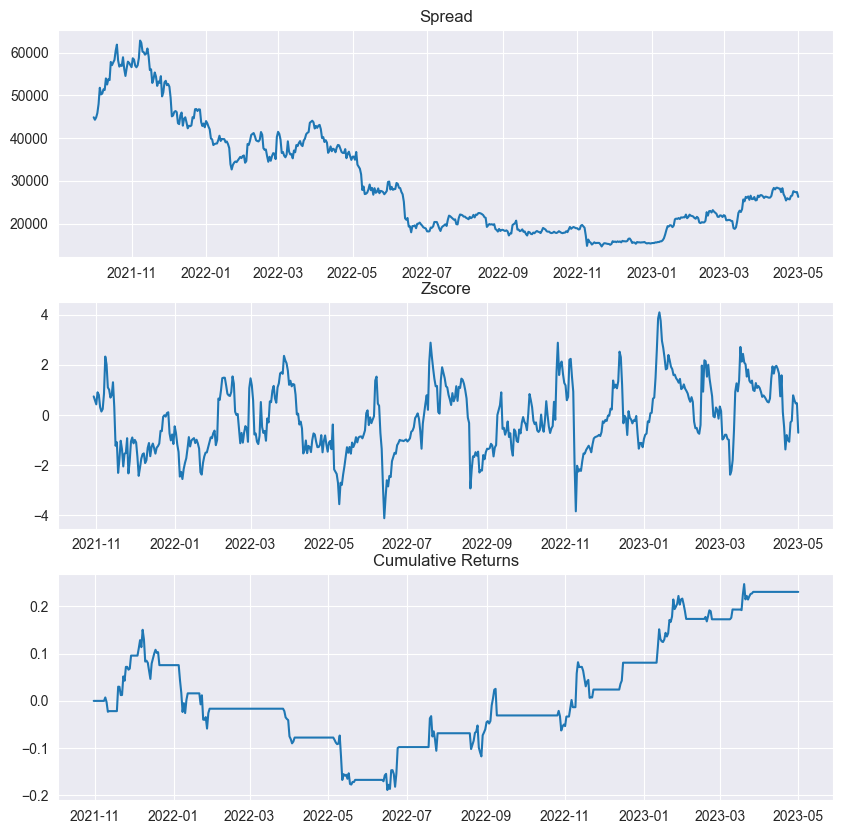

In [13]:
# below is one output example for the prompt above:

df = qs.preprocess_df(candles).reset_index(drop=True)

# Extract the price of BTC and ETH and compute their returns
btc_df = df[df['ticker'] == 'BTC-USD-SWAP'][['timestamp', 'close_price']]
btc_df.columns = ['timestamp', 'btc_price']
btc_df['btc_return'] = btc_df['btc_price'].pct_change()

eth_df = df[df['ticker'] == 'ETH-USD-SWAP'][['timestamp', 'close_price']]
eth_df.columns = ['timestamp', 'eth_price']
eth_df['eth_return'] = eth_df['eth_price'].pct_change()

# Calculate the spread and zscore of the spread
spread_df = pd.merge(btc_df, eth_df, on='timestamp')
spread_df['spread'] = spread_df['btc_price'] - spread_df['eth_price']
spread_df['zscore'] = (spread_df['spread'] - spread_df['spread'].rolling(window=30).mean()) / spread_df['spread'].rolling(window=30).std()

# Implement the trading strategy
spread_df['position'] = np.nan
spread_df.loc[spread_df['zscore'] > 2, 'position'] = 1
spread_df.loc[spread_df['zscore'] < -2, 'position'] = -1
spread_df.loc[(spread_df['zscore'] > -1) & (spread_df['zscore'] < 1), 'position'] = 0
spread_df['position'] = spread_df['position'].fillna(method='ffill')

spread_df['btc_holding'] = spread_df['position']
spread_df['eth_holding'] = -spread_df['position']

spread_df['btc_returns'] = spread_df['btc_return'] * spread_df['btc_holding'].shift(1)
spread_df['eth_returns'] = spread_df['eth_return'] * spread_df['eth_holding'].shift(1)

spread_df['strategy_returns'] = spread_df['btc_returns'] + spread_df['eth_returns']
spread_df['cumulative_returns'] = (1 + spread_df['strategy_returns']).cumprod() - 1

# Plot the spread, zscore, and cumulative return in separate subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(spread_df['timestamp'], spread_df['spread'])
axs[0].set_title('Spread')
axs[1].plot(spread_df['timestamp'], spread_df['zscore'])
axs[1].set_title('Zscore')
axs[2].plot(spread_df['timestamp'], spread_df['cumulative_returns'])
axs[2].set_title('Cumulative Returns')
plt.show()